# Forecasting with Temporal Fusion Transformers

In [1]:
import holidays
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import pickle

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.metrics import mean_absolute_error, mean_squared_error

Set the float32 matmul precision to high to speed up computation

In [2]:
torch.set_float32_matmul_precision('medium')

Read the dataframe

In [3]:
df = pd.read_csv('../data/renfe_tft/output.csv')
print(f'Number of passengers: {len(df)}')
df.head()

Number of passengers: 1906235


,id,user_pattern,departure_station,arrival_station,arrival_day,arrival_time,purchase_day,service,service_departure_time,service_arrival_time,seat,price,utility,best_service,best_seat,best_utility
0,489461,Business,60000,71801,2023-04-10,7.735071,10,03063_10-04-2023-06.30,6.5,9.333333,Premium,90.03,1.916529,03063_10-04-2023-06.30,Premium,1.916529
1,62082,Business,60000,71801,2023-01-09,6.833554,9,03063_09-01-2023-06.30,6.5,9.333333,Premium,71.95,4.271485,03063_09-01-2023-06.30,Premium,4.271485
2,448260,Business,60000,71801,2023-04-04,6.856650,9,03063_04-04-2023-06.30,6.5,9.333333,Premium,116.09,0.841291,03063_04-04-2023-06.30,Premium,0.841291
3,538920,Business,60000,71801,2023-04-17,7.877119,9,03063_17-04-2023-06.30,6.5,9.333333,Premium,71.62,3.484014,03063_17-04-2023-06.30,Premium,3.484014
4,571727,Business,60000,71801,2023-04-23,8.779342,9,03083_23-04-2023-08.30,8.5,11.250000,Premium,132.48,1.196724,03083_23-04-2023-08.30,Premium,1.196724


Drop passengers that don't buy a ticket

In [4]:
df = df[df['service'].notna()]
print(f'Number of passengers: {len(df)}')

Number of passengers: 617098


Convert arrival_day to datetime

In [5]:
df['arrival_day'] = pd.to_datetime(df['arrival_day'])

Group the passengers per seat and arrival day to get the number of tickets sold

In [6]:
df_ticket_sold = df.groupby(by=['seat', 'arrival_day']).size().to_frame()
df_ticket_sold.columns = ['tickets_sold']
df_ticket_sold

tickets_sold
seat    arrival_day              
Basico  2023-01-01           2335
        2023-01-02           1600
        2023-01-03           1393
        2023-01-04           1142
        2023-01-05           1237
...                           ...
Premium 2023-12-27            200
        2023-12-28            200
        2023-12-29            600
        2023-12-30            250
        2023-12-31            453

[1086 rows x 1 columns]

Group the passegners per seat and arrival day to get the mean price and utility

In [7]:
df_price_utility = df.groupby(by=['seat', 'arrival_day'])[['price', 'utility']].mean()
df_price_utility

price    utility
seat    arrival_day                       
Basico  2023-01-01    47.125430   3.424843
        2023-01-02    28.745313   3.251655
        2023-01-03    36.165499   2.097801
        2023-01-04    25.439116   3.636371
        2023-01-05    31.744155   2.108192
...                         ...        ...
Premium 2023-12-27   105.412500   1.613575
        2023-12-28   125.062500   1.326163
        2023-12-29   135.897500   9.665082
        2023-12-30   117.836000  11.401518
        2023-12-31   153.223841  10.713782

[1086 rows x 2 columns]

Concat the previous dataframes

In [8]:
df = pd.concat([df_ticket_sold, df_price_utility], axis=1)
df

tickets_sold       price    utility
seat    arrival_day                                     
Basico  2023-01-01           2335   47.125430   3.424843
        2023-01-02           1600   28.745313   3.251655
        2023-01-03           1393   36.165499   2.097801
        2023-01-04           1142   25.439116   3.636371
        2023-01-05           1237   31.744155   2.108192
...                           ...         ...        ...
Premium 2023-12-27            200  105.412500   1.613575
        2023-12-28            200  125.062500   1.326163
        2023-12-29            600  135.897500   9.665082
        2023-12-30            250  117.836000  11.401518
        2023-12-31            453  153.223841  10.713782

[1086 rows x 3 columns]

Add missing dates and seats

In [9]:
df = df.unstack().fillna(0).stack()
df

tickets_sold       price    utility
seat    arrival_day                                     
Basico  2023-01-01         2335.0   47.125430   3.424843
        2023-01-02         1600.0   28.745313   3.251655
        2023-01-03         1393.0   36.165499   2.097801
        2023-01-04         1142.0   25.439116   3.636371
        2023-01-05         1237.0   31.744155   2.108192
...                           ...         ...        ...
Premium 2023-12-27          200.0  105.412500   1.613575
        2023-12-28          200.0  125.062500   1.326163
        2023-12-29          600.0  135.897500   9.665082
        2023-12-30          250.0  117.836000  11.401518
        2023-12-31          453.0  153.223841  10.713782

[1095 rows x 3 columns]

Reset the index of the dataframe

In [10]:
df = df.reset_index()
df

,seat,arrival_day,tickets_sold,price,utility
0,Basico,2023-01-01,2335.0,47.125430,3.424843
1,Basico,2023-01-02,1600.0,28.745313,3.251655
2,Basico,2023-01-03,1393.0,36.165499,2.097801
3,Basico,2023-01-04,1142.0,25.439116,3.636371
4,Basico,2023-01-05,1237.0,31.744155,2.108192
...,...,...,...,...,...
1090,Premium,2023-12-27,200.0,105.412500,1.613575
1091,Premium,2023-12-28,200.0,125.062500,1.326163
1092,Premium,2023-12-29,600.0,135.897500,9.665082
1093,Premium,2023-12-30,250.0,117.836000,11.401518


Add to the dataframe new features

Test include price, utility and other features

In [11]:
# Add time features
df['month'] = df['arrival_day'].dt.month
df['day'] = df['arrival_day'].dt.day
df['weekday'] = df['arrival_day'].dt.weekday
df['days_from_start'] = (df['arrival_day'] - df['arrival_day'].min()).dt.days

# Add holiday features
# TODO: Add regional and local holidays
es_holidays = holidays.ES()
df['national_holiday'] = df['arrival_day'].apply(lambda x: es_holidays.get(x) if x in es_holidays else 'X')
df

,seat,arrival_day,tickets_sold,price,utility,month,day,weekday,days_from_start,national_holiday
0,Basico,2023-01-01,2335.0,47.125430,3.424843,1,1,6,0,X
1,Basico,2023-01-02,1600.0,28.745313,3.251655,1,2,0,1,X
2,Basico,2023-01-03,1393.0,36.165499,2.097801,1,3,1,2,X
3,Basico,2023-01-04,1142.0,25.439116,3.636371,1,4,2,3,X
4,Basico,2023-01-05,1237.0,31.744155,2.108192,1,5,3,4,X
...,...,...,...,...,...,...,...,...,...,...
1090,Premium,2023-12-27,200.0,105.412500,1.613575,12,27,2,360,X
1091,Premium,2023-12-28,200.0,125.062500,1.326163,12,28,3,361,X
1092,Premium,2023-12-29,600.0,135.897500,9.665082,12,29,4,362,X
1093,Premium,2023-12-30,250.0,117.836000,11.401518,12,30,5,363,X


Exploratory data analysis

In [12]:
df[['seat', 'tickets_sold']].groupby(by='seat').mean()

,tickets_sold
seat,
Basico,1176.347945
Elige,210.309589
Premium,304.021918


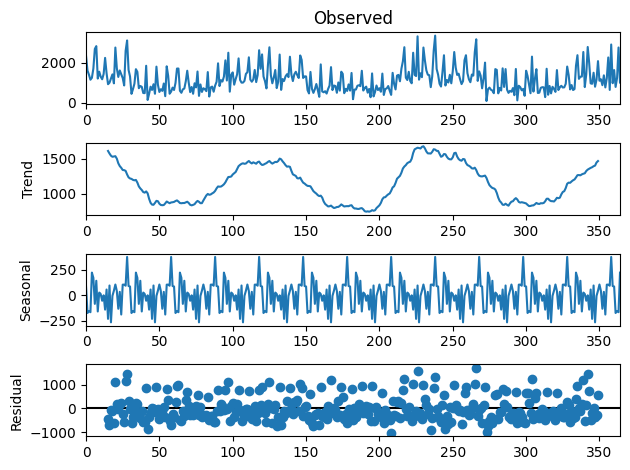

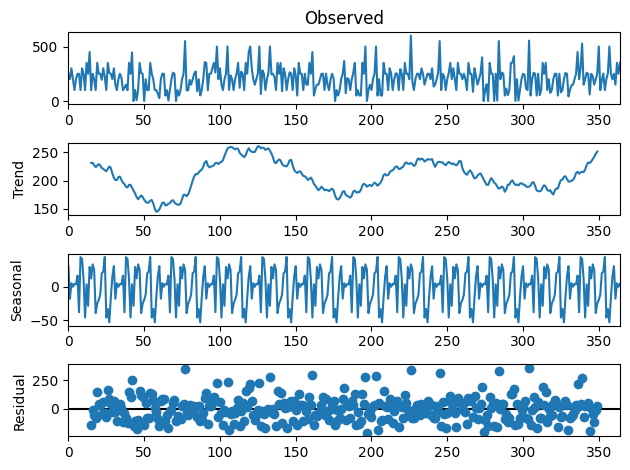

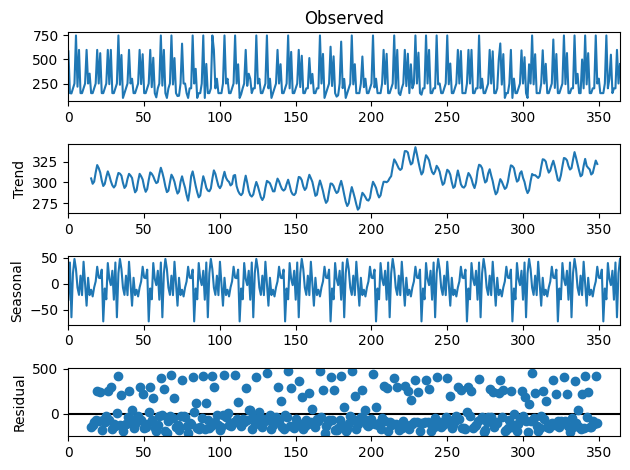

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = [value[0] for value in df[df['seat'] == 'Basico'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

series = [value[0] for value in df[df['seat'] == 'Elige'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

series = [value[0] for value in df[df['seat'] == 'Premium'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

Create training and validation time series dataset

In [14]:
min_prediction_length = 1 # We want to predict the next day
max_prediction_length = 3 # We want to predict the next 3 days
max_encoder_length = 4 * 7 # We want to use 4 weeks of data to predict the next 7 days
training_cutoff = df['days_from_start'].max() - max_prediction_length

In [15]:
training = TimeSeriesDataSet(
    df[lambda x: x.days_from_start <= training_cutoff],
    time_idx='days_from_start',
    target='tickets_sold',
    group_ids=['seat'],
    min_encoder_length=max_encoder_length // 2, # TODO: Check if this is correct
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['seat', 'national_holiday'],
    time_varying_known_reals=['days_from_start', 'day', 'weekday', 'month', 'price', 'utility'],
    time_varying_unknown_reals=['tickets_sold'],
    target_normalizer=GroupNormalizer(groups=['seat'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

In [16]:
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [17]:
# Create dataloaders for our model
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=16)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=16)

In [18]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).cpu()
baseline_predictions = Baseline().predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, baseline_predictions)
mse = mean_squared_error(actuals, baseline_predictions)
print(f'Baseline MAE: {mae}')
print(f'Baseline MSE: {mse}')

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 427.0
Baseline MSE: 494933.0


Train the TFT model

In [19]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=True, mode='min')
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger('lightning_logs')  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
--------------------------------------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 232.448


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 69.834 >= min_delta = 0.0001. New best score: 162.613


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.951 >= min_delta = 0.0001. New best score: 153.663


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.119 >= min_delta = 0.0001. New best score: 143.543


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.846 >= min_delta = 0.0001. New best score: 136.698


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.252 >= min_delta = 0.0001. New best score: 130.446


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.459 >= min_delta = 0.0001. New best score: 123.987


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.296 >= min_delta = 0.0001. New best score: 120.691


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.007 >= min_delta = 0.0001. New best score: 118.684


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 23.224 >= min_delta = 0.0001. New best score: 95.460


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 15.996 >= min_delta = 0.0001. New best score: 79.464


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 19.170 >= min_delta = 0.0001. New best score: 60.294


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.419 >= min_delta = 0.0001. New best score: 59.875


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.086 >= min_delta = 0.0001. New best score: 55.789


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.904 >= min_delta = 0.0001. New best score: 51.885


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.445 >= min_delta = 0.0001. New best score: 48.440


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 48.440. Signaling Trainer to stop.


In [20]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu()
predictions = tft.predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
print(f'Baseline MAE: {mae}')
print(f'Baseline MSE: {mse}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 110.1230239868164
Baseline MSE: 33789.69140625


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


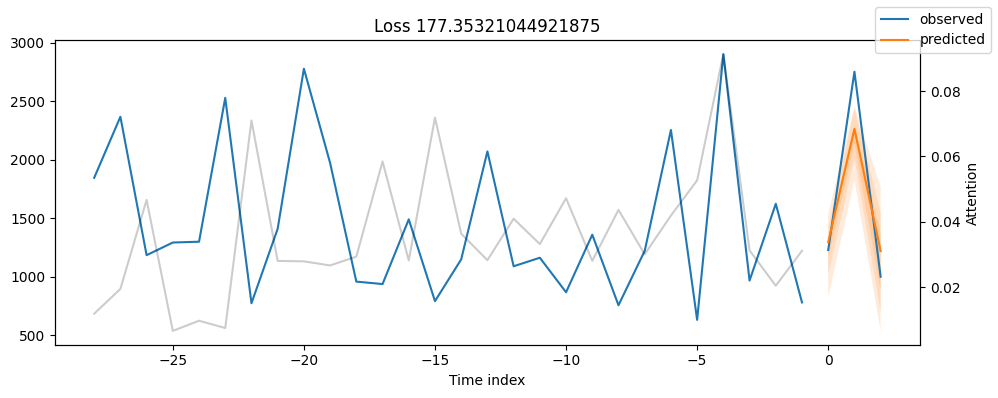

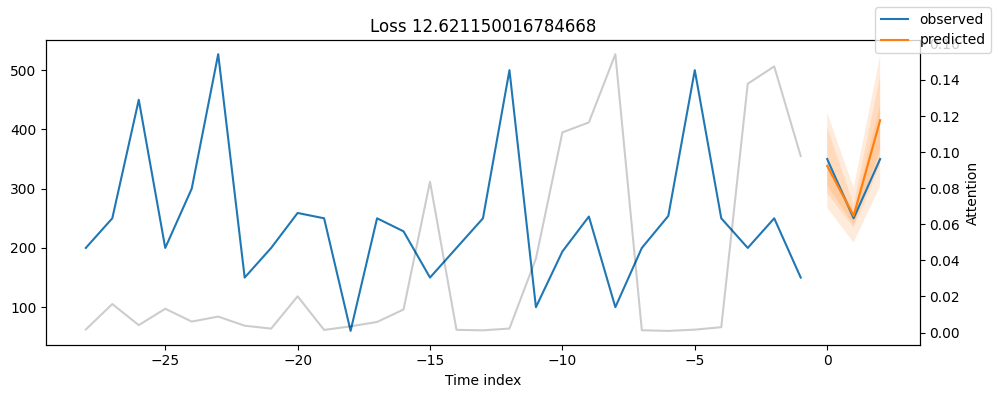

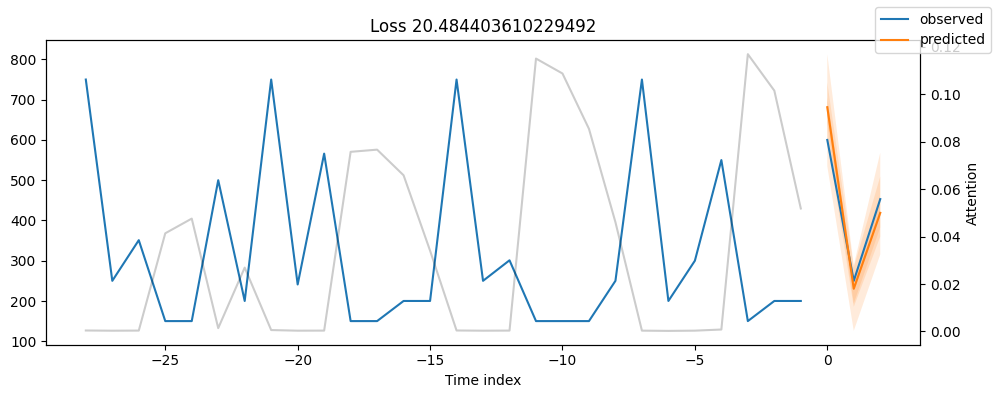

In [21]:
raw_predictions, x, _, _, _ = tft.predict(val_dataloader, mode='raw', return_x=True)
for idx in range(3):
    fig, ax = plt.subplots(figsize=(10, 4))
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True, ax=ax)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x400 with 1 Axes>,
 'decoder_variables': <Figure size 700x375 with 1 Axes>}

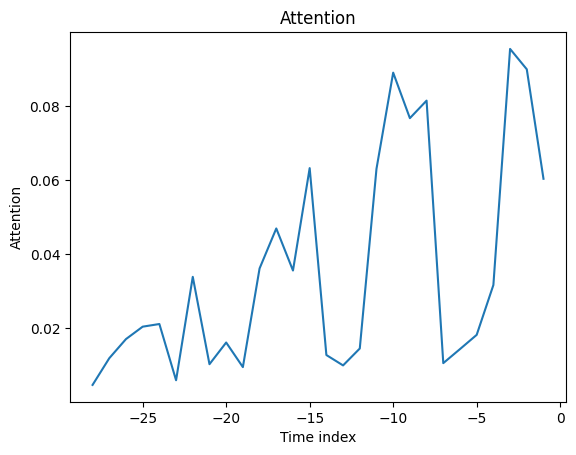

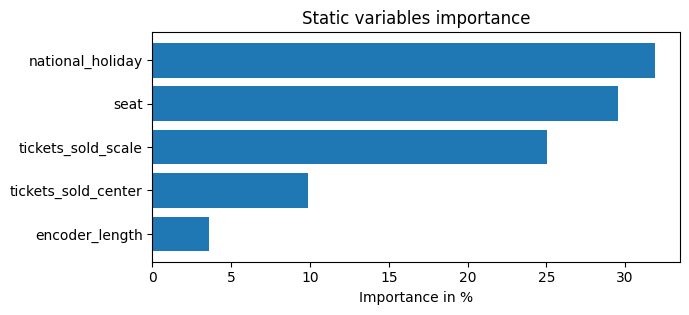

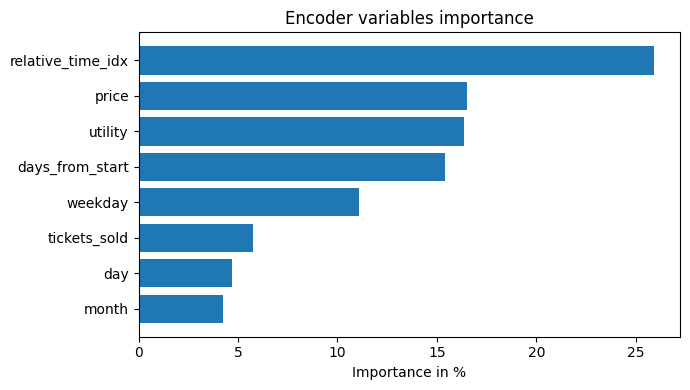

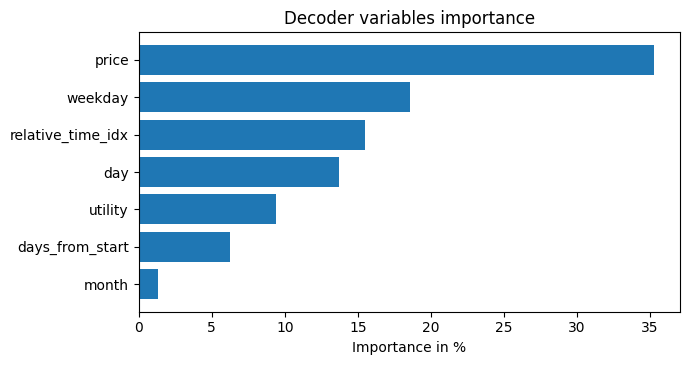

In [22]:
interpretation = tft.interpret_output(raw_predictions, reduction='sum')
tft.plot_interpretation(interpretation)

In [23]:
#Analysis on the val set

# predictions, x, _, _, _ = tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
# tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [24]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path='optuna_test',
    n_trials=10,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False 
)

# save study results
with open('test_study.pkl', 'wb') as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2023-05-17 17:31:11,673] A new study created in memory with name: no-name-76807fd9-9376-4237-8089-a2f81ab67eaf
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

{'gradient_clip_val': 0.039064747945227234, 'hidden_size': 32, 'dropout': 0.27116680915711816, 'hidden_continuous_size': 30, 'attention_head_size': 2, 'learning_rate': 0.07104825070487328}
